# test for particle interpolation functions

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# plot a 2-d field
def plot_field(X,title,vmin=0,vmax=1):
    plt.imshow(X,vmin=vmin,vmax=vmax,cmap="GnBu",origin='lower')
    plt.colorbar()
    plt.grid()
    plt.title(title)
    plt.show()

In [3]:
# plot a uv vector field
def plot_vector_field(X,U,V,title,vmin=0,vmax=1):
    # image
    plt.imshow(X,vmin=vmin,vmax=vmax,cmap="GnBu",origin='lower')
    plt.colorbar()
    plt.grid()
    plt.title(title)
    # UV field
    H, W = U.shape
    X, Y = np.meshgrid(np.arange(0, H, 1), np.arange(0, W, 1))
    n = 3
    plt.quiver(X[::n,::n], Y[::n,::n], 
               U[::n,::n], V[::n,::n], units='xy' ,scale=2, color='red')
    # 
    plt.show()

In [4]:
device = torch.device("cpu")
# input: B, C, H, W
# flow: [B, 2, H, W]
def warp(input, flow):
    B, C, H, W = input.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1).to(device)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W).to(device)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()
    vgrid = grid + flow

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0
    vgrid = vgrid.permute(0, 2, 3, 1)
    output = torch.nn.functional.grid_sample(input, vgrid)
    return output

Then, we set parameters.

In [5]:
# define size
height = 50
width = 50
# define position of circle
ic = 25
jc = 25
# spatial scale
scale = 5
# velocity
u = 5.0
v = 5.0

After this, we begin to create the initial field

In [160]:
# create initial field
R = torch.zeros(1,1,height,width)

In [161]:
# create xy grid
xx = torch.arange(0, width).view(1, -1).repeat(height, 1).float()
yy = torch.arange(0, height).view(-1, 1).repeat(1, width).float()

In [162]:
xx-ic

tensor([[-25., -24., -23.,  ...,  22.,  23.,  24.],
        [-25., -24., -23.,  ...,  22.,  23.,  24.],
        [-25., -24., -23.,  ...,  22.,  23.,  24.],
        ...,
        [-25., -24., -23.,  ...,  22.,  23.,  24.],
        [-25., -24., -23.,  ...,  22.,  23.,  24.],
        [-25., -24., -23.,  ...,  22.,  23.,  24.]])

In [163]:
yy-jc

tensor([[-25., -25., -25.,  ..., -25., -25., -25.],
        [-24., -24., -24.,  ..., -24., -24., -24.],
        [-23., -23., -23.,  ..., -23., -23., -23.],
        ...,
        [ 22.,  22.,  22.,  ...,  22.,  22.,  22.],
        [ 23.,  23.,  23.,  ...,  23.,  23.,  23.],
        [ 24.,  24.,  24.,  ...,  24.,  24.,  24.]])

In [164]:
R[0,0,:,:] = torch.exp(-((xx-ic)**2 + (yy-ic)**2)/scale**2)

In [165]:
# max value and min value
R.max(), R.min()

(tensor(1.), tensor(1.9287e-22))

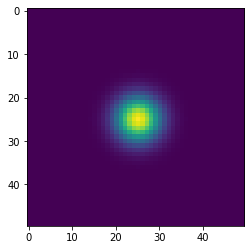

In [166]:
# plot on a grid
plt.imshow(R[0,0,:,:].numpy())

We now move the field with warp() function.

In [167]:
U = torch.ones(1,1,height,width)*u
V = torch.ones(1,1,height,width)*v
UV = torch.cat((U,V),dim=1)

In [168]:
U

tensor([[[[5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]]]])

In [169]:
V

tensor([[[[5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]]]])

In [170]:
UV.shape

torch.Size([1, 2, 50, 50])

In [171]:
Rw = warp(R, -UV)

align corners = True, Falseの違いは以下の通り。今回はFalseのままで良いような気がする。

https://discuss.pytorch.org/t/what-we-should-use-align-corners-false/22663/9

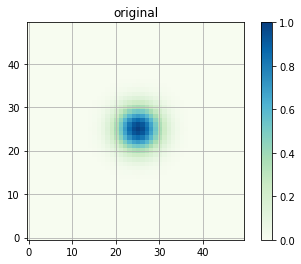

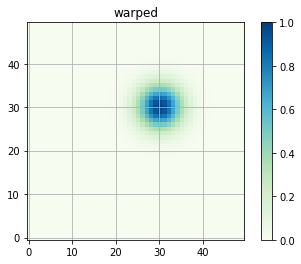

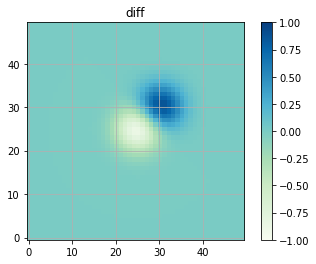

In [172]:
# plot on a grid
plot_field(R[0,0,:,:].numpy(),"original")
# plot on a grid
plot_field(Rw[0,0,:,:].numpy(),"warped")
# plot on a grid
plot_field((Rw[0,0,:,:]-R[0,0,:,:]).numpy(),"diff",vmin=-1,vmax=1)

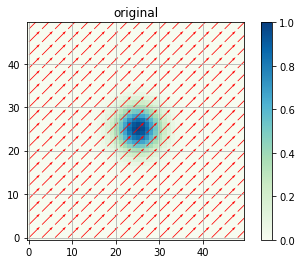

In [195]:
# plot on a grid
plot_vector_field(R[0,0,:,:].numpy(),UV[0,0,:,:].numpy(),
                  UV[0,1,:,:].numpy(),"original")

In [178]:
UV

tensor([[[[5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]],

         [[5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          ...,
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.],
          [5., 5., 5.,  ..., 5., 5., 5.]]]])

In [182]:
z = np.zeros((5,5))

In [183]:
z

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [184]:
z.shape

(5, 5)